In [13]:
import osmium
import shapely.wkb as wkblib
#import osmnx as ox
import geopandas
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import random

In [2]:
#load any country you need -- exchange "Sweden" for some other country at your own risk!
!wget https://download.geofabrik.de/europe/austria-latest.osm.pbf -P ./

--2023-04-15 20:23:32--  https://download.geofabrik.de/europe/austria-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.50.43, 65.109.48.72
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.50.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 714846436 (682M) [application/octet-stream]
Saving to: ‘./austria-latest.osm.pbf.1’

austria-latest.osm. 100%[===================>] 681.73M  36.6MB/s    in 19s     

2023-04-15 20:23:50 (36.8 MB/s) - ‘./austria-latest.osm.pbf.1’ saved [714846436/714846436]



In [3]:
#you will need docker for this cell, but you can also skip this, it makes loading the osm-file faster
#!docker run -d -w /wkd -v $(pwd):/wkd stefda/osmium-tool osmium tags-filter -o sweden-filtered.osm.pbf sweden-latest.osm.pbf building

In [4]:
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.nodes_count = 0
        self.nodes = []
        self.building_count = 0
        self.buildings = []
        # A global factory that creates WKB from a osmium geometry
        self.wkbfab = osmium.geom.WKBFactory()

    def node(self, n):
        if n.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_point(n)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": n.id, "geometry": geo }
            
            for key, value in n.tags:
                row[key] = value
                
            self.nodes.append(row)
            self.nodes_count += 1
        
    def area(self, w):
        if w.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_multipolygon(w)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": w.id, "geometry": geo }

            for key, value in w.tags:
                row[key] = value

            self.buildings.append(row)
            self.building_count += 1

## finding closest building with levels info for every building without levels info

In [14]:
file = "sweden-filtered.osm.pbf"

In [15]:
def build_geodf(file):
    
    buildinghandler = BuildingHandler()
    buildinghandler.apply_file(file, locations=True)
    
    i = 200000
    while i-200000 < len(buildinghandler.buildings):
        dfx = pd.DataFrame(buildinghandler.buildings[(i-200000):min([i, len(buildinghandler.buildings)-1])])
        gdfx = geopandas.GeoDataFrame(dfx, geometry='geometry')
        gdfx = gdfx.set_crs("EPSG:4326")
        #gdfx = ox.project_gdf(gdfx)
        #gdfx = gdfx.dropna(subset=['building:levels'])
        gdfx = gdfx[['w_id', 'geometry', 'building:levels']]
        if i < 200001:
            meta = gdfx
        else:
            meta = pd.concat([meta, gdfx])
        print(meta.shape)
        i += 200000
    
    return meta

In [16]:
df = build_geodf(file)

invalid area (area_id=2323208800)
invalid area (area_id=2324227006)
(200000, 3)
(400000, 3)
(600000, 3)
(800000, 3)
(1000000, 3)
(1200000, 3)
(1400000, 3)
(1600000, 3)
(1800000, 3)
(2000000, 3)
(2103704, 3)


In [17]:
geodf = df.copy()

In [18]:
def predict_levels(with_levels_info, without_levels_info, k_neighbours):
     # scaling to zero mean and unit variance, seems to lower accuracy.
    """for i in [0,1,2]:
        with_levels_info[:,i] = (with_levels_info[:,0] - np.mean(with_levels_info[:,0])) / np.std(with_levels_info[:,0])
        without_levels_info[:,i] = (without_levels_info[:,0] - np.mean(without_levels_info[:,0])) / np.std(without_levels_info[:,0])"""
    
    distances = cdist(without_levels_info[:,[0,1,2]], with_levels_info[:,[0,1,2]])
    idx = np.argpartition(distances, k_neighbours, axis=1)
    closest_k = idx[:,:k_neighbours]
    means = []
    for c in range(closest_k.shape[0]):
        means.append(int(np.mean(with_levels_info[closest_k[c,:], 3])))
    return means

## Making DataFrame of buildings along with predicted number of levels

In [19]:
k_neighbours = 3

In [20]:
def build_data_with_predictions(geodf, k_neighbours):
    
    geodf["geometry"] = geodf["geometry"].to_crs("EPSG:3857") # to meters instead of lat, lon degees
    geodf.loc[geodf['building:levels'].str.contains('[A-Za-z]', na=False)] = None
    geodf.loc[geodf['building:levels'].str.contains('[;,.-]', na=False)] = None
    geodf.loc[geodf['building:levels'] == "0"] = None
    geodf["building:levels"] = geodf["building:levels"].astype("float")
    
    areas = geodf["geometry"].area
    locations = geodf["geometry"].centroid
    levels = geodf["building:levels"]
    data = np.array([areas, locations.x, locations.y, levels]).T
    predicted = np.isnan(data[:,3]).reshape(-1,1)
    data = np.concatenate([data, predicted], axis=1)
    
    with_levels_info = data[np.where(~np.isnan(data[:,3]))]
    
    step = 10000
    L = []

    for i in range(0, data.shape[0], step):
        current = data[i:i+step,:]
        current_without_levels_info = np.where(np.isnan(current[:,3]))[0]
        means = predict_levels(with_levels_info, current[current_without_levels_info,:], k_neighbours)
        current[current_without_levels_info, 3] = means
        L.append(current)
        
    data = np.concatenate(L)
    
    df = pd.DataFrame({"base_area": data[:,0], "x": data[:,1], "y": data[:,2],
                       "levels": data[:,3], "predicted": data[:,4]})
    return df

D = build_data_with_predictions(geodf, k_neighbours)

In [21]:
D

,base_area,x,y,levels,predicted
0,138563.298940,1.368668e+06,7.897929e+06,2.0,1.0
1,6526.917677,1.374833e+06,8.034088e+06,1.0,1.0
2,48011.073424,1.995770e+06,8.320986e+06,4.0,0.0
3,12812.965688,2.014934e+06,8.252783e+06,3.0,0.0
4,1994.636688,2.014541e+06,8.252463e+06,2.0,0.0
...,...,...,...,...,...
2103699,294.822273,1.455117e+06,7.668642e+06,2.0,1.0
2103700,606.718745,1.455118e+06,7.668663e+06,2.0,1.0
2103701,347.616274,1.455047e+06,7.668650e+06,2.0,1.0
2103702,520.651090,1.455072e+06,7.668700e+06,2.0,1.0


In [29]:
geodf['new_level'] = D['levels']

In [31]:
geodf['area'] = geodf.area

In [41]:
geodf['floorarea'] = geodf.area * geodf['new_level']

In [33]:
geodf

,w_id,geometry,building:levels,new_level,area
0,7.375636e+06,"MULTIPOLYGON (((1368268.549 7897390.408, 13682...",NaN,2.0,138563.298940
1,9.702388e+06,"MULTIPOLYGON (((1374772.913 8034151.557, 13747...",NaN,1.0,6526.917677
2,9.934046e+06,"MULTIPOLYGON (((1995571.501 8321153.404, 19955...",4.0,4.0,48011.073424
3,1.034977e+07,"MULTIPOLYGON (((2014862.134 8252746.538, 20149...",3.0,3.0,12812.965688
4,1.038407e+07,"MULTIPOLYGON (((2014504.008 8252479.749, 20145...",2.0,2.0,1994.636688
...,...,...,...,...,...
103699,2.325151e+09,"MULTIPOLYGON (((1455104.854 7668636.758, 14551...",NaN,4.0,294.822273
103700,2.325151e+09,"MULTIPOLYGON (((1455102.483 7668651.743, 14551...",NaN,2.0,606.718745
103701,2.325151e+09,"MULTIPOLYGON (((1455037.071 7668640.899, 14550...",NaN,2.0,347.616274
103702,2.325151e+09,"MULTIPOLYGON (((1455060.593 7668686.197, 14550...",NaN,2.0,520.651090


## Testing k-nearest accuracy against dummy model

In [13]:

def accuracy_test(dataframe, leave_out_fraction, k_neighbours):
    
    known = dataframe.loc[dataframe["predicted"] == 0]
    known_index = list(known.index)
    
    mean_errors = []
    mean_dummy_errors = []
     
    for i in range(10):
        
        random.shuffle(known_index)
        to_predict = known_index[:int(leave_out_fraction*len(known_index))]
        to_use = known_index[int(leave_out_fraction*len(known_index)):]
        true_levels = dataframe.iloc[to_predict]["levels"]
        predicted_levels = predict_levels(np.array(dataframe.iloc[to_use]), np.array(dataframe.iloc[to_predict]), k_neighbours)
        
        mean_abs_error = np.mean(np.abs(true_levels - predicted_levels))
        mean_errors.append(mean_abs_error)
        
        mean_dummy_error = np.mean(np.abs(true_levels - np.mean(np.array(dataframe.iloc[to_use])[:,3]))) # error in assigning unknown values as mean of known ones
        mean_dummy_errors.append(mean_dummy_error)

    print(f"Mean Absolute Error using k-nearest: {np.mean(mean_errors)}")
    print(f"Mean Absolute Error using dummy model: {np.mean(mean_dummy_errors)}")
    
    

    
accuracy_test(D, 0.1, k_neighbours)

Mean Absolute Error using k-nearest: 0.6325642141924249
Mean Absolute Error using dummy model: 1.0203369445792005


In [34]:
#loading european climate zones:
from shapely.geometry import Polygon

def make_polygon(list1, list2):
    return Polygon(zip(list1, list2))

lat_point_list4 = [40.38, 45.52, 49.09, 55.03, 58.68, 58.74, 60.58, 60.52, 59.47, 59.15, 59.84, 
                   60.26, 59.04, 59.02, 59.60, 59.35, 61.36, 62.06, 63.41, 62.17, 62.90, 54.29, 
                   53.26, 52.69, 53.88, 53.67, 52.03, 51.31, 49.83, 48.08, 45.42, 44.89, 45.38, 
                   44.52, 44.39, 43.77, 44.04, 45.35, 43.84, 43.39, 40.38]
lon_point_list4 = [21.88, 15.56, 15.38, 20.04, 23.56, 21.26, 21.14, 18.46, 18.36, 17.71, 16.83, 
                   16.88, 15.16, 12.52, 10.50, 8.57, 8.29, 6.57, 7.18, -22.63, -23.21, -9.40, 
                   -9.11, -7.14, -6.10, -4.01, -4.82, -4.65, -0.01, -1.23, 0.92, 5.50, 7.18, 7.70, 
                   10.31, 11.70, 13.30, 13.50, 15.55, 17.61, 21.88]

polygon_geom4 = make_polygon(lon_point_list4, lat_point_list4)

lat_point_list5 = [61.36, 60.32, 62.17, 61.83, 60.72, 61.74, 60.33, 60.53, 59.05, 59.55, 49.84, 45.27, 
                   37.51, 37.71, 35.10, 38.69, 37.65, 39.02, 37.71, 39.77, 41.44, 40.45, 41.57, 42.23, 
                   44.40, 41.97, 40.58, 40.38, 45.52, 49.09, 55.03, 58.68, 58.74, 60.58, 60.52, 59.47, 
                   59.15, 59.84, 60.26, 59.04, 59.02, 59.60, 59.35, 61.36]
lon_point_list5 = [8.29, 16.46, 17.58, 21.41, 23.74, 31.01, 34.94, 50.59, 59.9, 62.14, 49.92, 58.18, 
                   58.18, 49.31, 48.78, 39.02, 36.74, 34.28, 33.05, 30.06, 33.84, 37.00, 41.75, 42.54, 
                   33.75, 27.69, 26.72, 21.88, 15.56, 15.38, 20.04, 23.56, 21.26, 21.14, 18.46, 18.36, 
                   17.71, 16.83, 16.88, 15.16, 12.52, 10.50, 8.57, 8.29]

polygon_geom5 = make_polygon(lon_point_list5, lat_point_list5)

lat_point_list5b = [45.51, 45.57, 45.22, 45.00, 45.19, 44.62, 44.43, 44.94, 45.51]
lon_point_list5b = [12.35, 8.72, 7.61, 8.26, 8.95, 10.29, 12.35, 12.66, 12.35]

polygon_geom5b = make_polygon(lon_point_list5b, lat_point_list5b)

lat_point_list7 = [70.24, 66.12, 63.00, 62.27, 61.36, 62.06, 63.41, 62.17, 62.90, 65.43, 65.28, 66.61, 64.61, 70.67, 70.24]
lon_point_list7 = [19.39, 13.43, 12.22, 8.89, 8.29, 6.57, 7.18, -22.63, -23.21, -23.50, -21.58, -17.29, -15.54, 17.85, 19.39]

polygon_geom7 = make_polygon(lon_point_list7, lat_point_list7)

lat_point_list8 = [73.50, 74.20, 71.43, 70.24, 66.12, 63.00, 62.27, 61.36, 60.32, 62.17, 61.83, 60.72, 61.74, 
                   60.33, 60.53, 59.05, 64.31, 67.17, 67.13, 73.50]
lon_point_list8 = [60.18, 51.70, 19.49, 19.39, 13.43, 12.22, 8.89, 8.29, 16.46, 17.58, 21.41, 23.74, 31.01, 
                   34.94, 50.59, 59.9, 54.73, 57.15, 59.27, 60.18]

polygon_geom8 = make_polygon(lon_point_list8, lat_point_list8)

lat_point_list3 = [54.29, 53.26, 52.69, 53.88, 53.67, 52.03, 51.31, 49.83, 48.08, 45.42, 44.89, 45.38, 44.52, 44.39, 43.77, 44.04, 45.35, 43.84, 43.39, 40.38, 40.58, 41.97, 44.40, 42.23, 41.57, 40.45, 41.44, 39.77, 37.71, 39.02, 37.65, 38.69, 35.10, 37.71, 37.51, 32.16, 32.16, 26.17, 26.17, 40.28, 55.65, 54.29]
lon_point_list3 = [-9.40, -9.11, -7.14, -6.10, -4.01, -4.82, -4.65, -0.01, -1.23, 0.92, 5.50, 7.18, 7.70, 10.31, 11.70, 13.30, 13.50, 15.55, 17.61, 21.88, 26.72, 27.69, 33.75, 42.54, 41.75, 37.00, 33.84, 30.06, 33.05, 34.28, 36.74, 39.02, 48.78, 49.31, 58.18, 58.18, -9.87, -15.44, -33.64, -33.64, -15.44, -9.40]

polygon_geom3 = make_polygon(lon_point_list3, lat_point_list3)

zones = geopandas.GeoDataFrame(index=['zone3','zone4', 'zone5', 'zone5b', 'zone7', 'zone8'], crs='epsg:4326', 
                                 geometry=[polygon_geom3, polygon_geom4, polygon_geom5, polygon_geom5b, polygon_geom7, polygon_geom8])       

zones

,geometry
zone3,"POLYGON ((-9.40000 54.29000, -9.11000 53.26000..."
zone4,"POLYGON ((21.88000 40.38000, 15.56000 45.52000..."
zone5,"POLYGON ((8.29000 61.36000, 16.46000 60.32000,..."
zone5b,"POLYGON ((12.35000 45.51000, 8.72000 45.57000,..."
zone7,"POLYGON ((19.39000 70.24000, 13.43000 66.12000..."
zone8,"POLYGON ((60.18000 73.50000, 51.70000 74.20000..."


<Axes: >

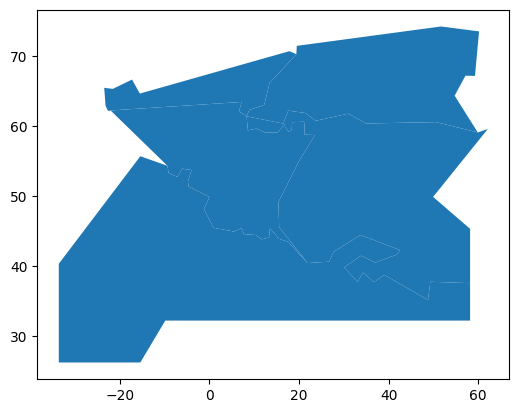

In [35]:
zones.plot()

In [54]:
kwhs = {4: 133.280, 5: 159.993, 6: 240.838, 7: 158.663, 8: 230.084}
for i in [4,5,8]:
    part = geodf.geometry.centroid.to_crs(zones.crs).within(zones.loc['zone'+str(i),'geometry'])
    geodf.loc[part,'kwh'] = geodf.loc[part]['floorarea'] * kwhs[i]

In [57]:
geodf['co2'] = 0

In [58]:
#using this article https://www.sei.org/publications/swedish-heat-energy-system-new-tensions-and-lock-ins-after-a-successful-transition/#:~:text=Fossil%20fuel%20energy%20has%20been,demand%20for%20heating%20in%20buildings.
#to calculate an estimate of the energy mix and it's co2-emissions using Antti's model
co2 = 0.5*0.195 + 0.25*0.104 + 0.08*0.255 + 0.08*0.354 + 0.09*0.403
co2

0.20848999999999998

In [59]:
geodf['co2'] = geodf['kwh'] * co2

In [61]:
minx, miny, maxx, maxy = geodf.total_bounds
print(minx, miny, maxx, maxy)

1223428.0095514595 7427637.039070617 2692199.74629556 10769596.830740549


In [ ]:
#UNDOABLE! TAKES FOREVER.
squares = []
sums = []

x = minx
y = miny
while x < maxx:
    y = miny
    while y < maxy:
        co2sum = geodf.cx[x:x+1000,y:y+1000].co2.sum()
        if co2sum > 0:
            lon_point_list = [x, x+1000, x+1000, x, x]
            lat_point_list = [y, y, y+1000, y+1000, y]
            squares.append(Polygon(zip(lon_point_list, lat_point_list)))
            sums.append(co2sum)
        y += 1000
    x += 1000

In [102]:
#creating a 2d array for all square tiles to cover the whole country (adding one for surity)
rows = int(np.floor((maxy - miny) / 1000))
cols = int(np.floor((maxx - minx) / 1000))
co2sums = np.zeros((rows+1,cols+1))

In [79]:
geodf['centroid'] = geodf.geometry.centroid

In [100]:
#for some reason some centroids are none
geodf = geodf.dropna(subset=['centroid'])

In [103]:
#summing up co2 for every row in the dataframe to the correct square tile in the grid
for index, row in geodf.iterrows():
    co2sums[int(np.floor((row.centroid.y-miny)/1000))][int(np.floor((row.centroid.x-minx)/1000))] += row.co2
    

In [111]:
squares = []
sums = []
for y in range(0, co2sums.shape[0]):
    for x in range(0, co2sums.shape[1]):
        co2 = co2sums[y,x]
        if co2 > 0:
            thisx = minx + x*1000
            thisy = miny + y*1000
            lon_point_list = [thisx, thisx+1000, thisx+1000, thisx, thisx]
            lat_point_list = [thisy, thisy, thisy+1000, thisy+1000, thisy]
            squares.append(Polygon(zip(lon_point_list, lat_point_list)))
            sums.append(co2)

In [115]:
sqdf = geopandas.GeoDataFrame(crs=geodf.crs, geometry=squares)
sqdf['co2'] = sums

In [124]:
sqdf['co2n'] = (sqdf.co2 - sqdf.co2.mean()) / sqdf.co2.std()

<Axes: >

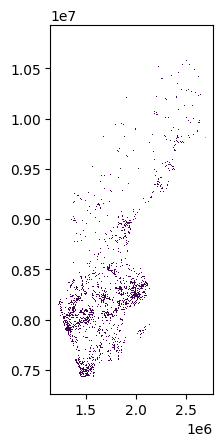

In [125]:
sqdf.plot(column=sqdf.co2n)

In [126]:
sqdf

,geometry,co2,co2n
0,"POLYGON ((1479428.010 7427637.039, 1480428.010...",1.483692e+05,-0.165978
1,"POLYGON ((1480428.010 7427637.039, 1481428.010...",1.873130e+05,-0.165861
2,"POLYGON ((1484428.010 7427637.039, 1485428.010...",2.914001e+05,-0.165546
3,"POLYGON ((1485428.010 7427637.039, 1486428.010...",2.963913e+05,-0.165531
4,"POLYGON ((1486428.010 7427637.039, 1487428.010...",8.190139e+05,-0.163952
...,...,...,...
149621,"POLYGON ((2322428.010 10720637.039, 2323428.01...",1.429486e+07,-0.123244
149622,"POLYGON ((2322428.010 10721637.039, 2323428.01...",4.215055e+07,-0.039095
149623,"POLYGON ((2266428.010 10741637.039, 2267428.01...",2.295764e+06,-0.159491
149624,"POLYGON ((2266428.010 10742637.039, 2267428.01...",1.668013e+07,-0.116038
